In [39]:
import glob2 as glob

import pandas as pd
import numpy as np

from rfpimp import *

from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier

from matplotlib import pyplot as plt

# import pickle

### First, import the data on which to train our model. To accommodate size constraints, we will train on only 2017 data for now.

In [40]:

# size_2015 = pd.concat([pd.read_csv(f) for f in glob.glob('Past3years/size_2015*.csv')], ignore_index=True)
# trip_2015 = pd.concat([pd.read_csv(f) for f in glob.glob('Past3years/trip_2015*.csv')], ignore_index = True)

# size_2016 = pd.concat([pd.read_csv(f) for f in glob.glob('Past3years/size_2016*.csv')], ignore_index=True)
# trip_2016 = pd.concat([pd.read_csv(f) for f in glob.glob('Past3years/trip_2016*.csv')], ignore_index = True)

size_2017 = pd.concat([pd.read_csv(f) for f in glob.glob('Past3years/size_2017*.csv')], ignore_index=True)
trip_2017 = pd.concat([pd.read_csv(f) for f in glob.glob('Past3years/trip_2017*.csv')], ignore_index = True)

/home/lubuntu/anaconda3/envs/project/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3185: DtypeWarning: Columns (26,39,65,73) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):
/home/lubuntu/anaconda3/envs/project/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3185: DtypeWarning: Columns (65) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


Each catch and trip has an ID code. Unfortunately, many of the ID codes are messed up and aren't actually all numbers...they end in 'XX' instead. Since we can't use these, we will make these into NaN.

In [41]:
ids=[]
for idno in trip_2017.ID_CODE:
    try: ids.append(int(idno))
    except: ids.append(np.nan)
        
trip_2017['new_id']=ids


## Choose the columns that aren't obviously cheating:

Several of the variables in our data, such as 'length of fish', wouldn't be something that you know before catching a fish. Thus, if we train a model on that it would perform better than in real life. This is cheating, also known as 'leaky' data.

Previous EDA also showed a high correlation between several variables, so we will select columns of non-correlated variables.

In [42]:
size_cols = ['AREA_X', 'ID_CODE', 'MODE_FX', 'SUB_REG', 'common'].copy()
trip_cols = ['AREA', 'BOAT_HRS', 'CNTRBTRS',
            'FFDAYS12', 'new_id','month'].copy()

In [43]:
size2017 = size_2017[size_cols].copy()
trip2017 = trip_2017[trip_cols].copy()


Now we can merge the two dataframes on common ID code.

In [44]:
merged = pd.merge(size2017,trip2017,how='inner', left_on=['ID_CODE'], right_on=['new_id'])

In [45]:
print(sum(merged.common.isnull()))
print(len(merged.common))

35662
176809


The column 'common' is the common name of the fish, and this is what we are predicting. We have to drop the fish that you don't have any name for, since we can't use these for training.

In [46]:
mask = merged.common.isnull()
data = merged[mask==False]

Now we need to drop the ID_CODE column since it is also going to be 'leaky' data.

In [47]:
data.drop(columns=['new_id', 'ID_CODE'], inplace=True)

/home/lubuntu/anaconda3/envs/project/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [48]:
data.head()

,AREA_X,MODE_FX,SUB_REG,common,AREA,BOAT_HRS,CNTRBTRS,FFDAYS12,month
9,5,3,4,ATLANTIC SILVERSIDE,C,NaN,1.0,100.0,9
13,5,3,4,ATLANTIC MENHADEN,C,NaN,1.0,20.0,9
14,5,3,4,ATLANTIC MENHADEN,C,NaN,1.0,20.0,9
15,5,3,4,ATLANTIC MENHADEN,C,NaN,1.0,20.0,9
16,5,3,4,ATLANTIC MENHADEN,C,NaN,1.0,20.0,9


### Now that the dataframes are merged, we can perform some exploratory data analysis (EDA)

Look at the unique values for each of our columns

In [49]:
for x in data:
    print(x)
    print(data[x].unique())

AREA_X
[5 1 2 3 4]
MODE_FX
[3 4 5 7]
SUB_REG
[4 5 6 7]
common
['ATLANTIC SILVERSIDE' 'ATLANTIC MENHADEN' 'SCUP' 'TAUTOG' 'BLUEFISH'
 'BLACK SEA BASS' 'CUNNER' 'STRIPED BASS' 'DOGFISH SHARK'
 'SUMMER FLOUNDER' 'STRIPED SEAROBIN' 'CHUB MACKEREL' 'ATLANTIC BONITO'
 'SHORTFIN MAKO' 'LITTLE TUNNY' 'SEAROBIN GENUS' 'ATLANTIC COD'
 'ACADIAN REDFISH' 'CUSK' 'POLLOCK' 'HADDOCK' 'RED HAKE'
 'ATLANTIC MACKEREL' 'WHITE HAKE' 'GOOSEFISH' 'WINTER SKATE'
 'AMERICAN SHAD' 'BLUEFIN TUNA' 'SILVER HAKE' 'ATLANTIC HERRING'
 'SPINY DOGFISH' 'NORTHERN KINGFISH' 'MENHADEN GENUS' 'KING MACKEREL'
 'UNIDENTIFIED (SHARKS)' 'GRAY TRIGGERFISH' 'HERRING GENUS' 'HICKORY SHAD'
 'NORTHERN SEAROBIN' 'STRIPED KILLIFISH' 'MUMMICHOG' 'CHANNEL CATFISH'
 'STRIPED MULLET' 'WHITE PERCH' 'ATLANTIC CROAKER' 'BLACK DRUM'
 'NORTHERN PUFFER' 'WEAKFISH' 'SOUTHERN KINGFISH' 'SHEEPSHEAD'
 'BLUE CATFISH' 'SPOT' 'SPOTTED SEATROUT' 'SILVER PERCH' 'PIGFISH'
 'SOUTHERN STINGRAY' 'PINFISH' 'BULLNOSE RAY' 'SPANISH MACKEREL'
 'WHITE CATFISH'

How many of the top 5 fish are caught each month?

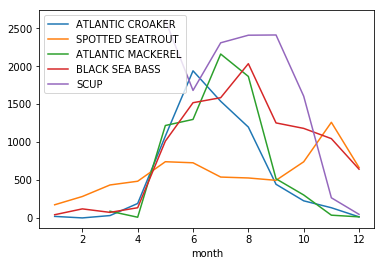

In [50]:
counts = data['common'].value_counts()
counts.sort_values(inplace=True)
fish = counts[-5:]

test = data.groupby(by='common')['month'].value_counts()

#fish = test['SCUP']
#fish2 = test['RED HAKE']

#fish.sort_index().plot()
# fish2.sort_index().plot()

for species in fish.index:
    test[species].sort_index().plot(legend=True, label=species)


If we look at each sub-region where fish are caught, which one is the most fruitful?

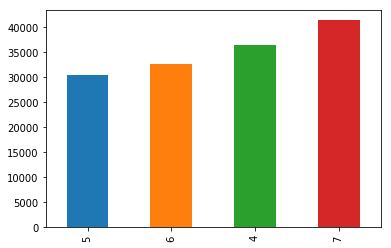

In [51]:
by_area = data['SUB_REG'].value_counts()
by_area.sort_values(inplace=True)
by_area[-10:].plot(kind='bar')

Can we see what the most common fish is for each sub-region? Running the code below for each sub region let's us see the answer.

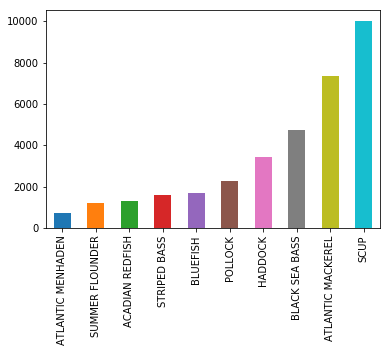

In [52]:
#get the most common fish for each sub-region
# merged.tail()

mask = data['SUB_REG']==4
region_1 = data[mask].copy()
# region_1
counts = region_1['common'].value_counts()
counts.sort_values(inplace=True)

#counts[-1]
counts[-10:].plot(kind='bar')

In [53]:
# Take the count of the most common fish in each region. If you always guess that, you'll get it right
# the same number of times that it appears. Add those up, and divide out of the total fish, and there's your baseline
# Region 4: 10019
# Region 5: 5137
# Region 6: 2718
# Region 7: 4003
accuracy = (10019+5137+2718+4003)/len(data)*100
print(accuracy)

15.499443842235399


### So, the total accuracy if you just guess the most common fish in each region, is 12.4% - 15.5% (depending on if you drop the NAs first or not)

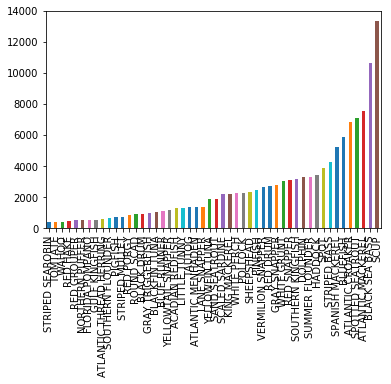

In [54]:
#Previously we looked by region, let's look overall at the to 50 fish
counts = data['common'].value_counts()
counts.sort_values(inplace=True)

counts[-50:].plot(kind='bar')

### Instead of predicting for every fish (which can get unruly), let's predict only fish that are caught more than 500 times a year.
We can also still include the less-caught species, but all rolled-up into one category as 'other'.

In [55]:
print(sum(counts>500))
print(500/data.shape[0]*100)
print(500/counts.sum()*100)

46
0.3542406143949216
0.3542406143949216


As seen above, there are only 46 species that had more than 500 catches. If a species was caught less than 500 times, it represents ~ 3.5% of the catches.

In [56]:
fish = counts.sum()
rates = [x/fish*100 for x in counts]
rates[-10:]

[2.422297321232474,
 2.731903618213636,
 3.020963959559891,
 3.714567082545148,
 4.171537475114597,
 4.836801348948259,
 5.018172543518459,
 5.327070359270831,
 7.54532508661183,
 9.446888704683769]

In [57]:
# Here, we make a separate column that countains the count for each species. Then we drop those that are too low.
df_count = pd.DataFrame()
df_count['counts'] = counts
df_count['common'] = counts.index
totals = pd.merge(data, df_count, how="inner")
totals.head()
#df_count.head()

,AREA_X,MODE_FX,SUB_REG,common,AREA,BOAT_HRS,CNTRBTRS,FFDAYS12,month,counts
0,5,3,4,ATLANTIC SILVERSIDE,C,NaN,1.0,100.0,9,13
1,5,3,5,ATLANTIC SILVERSIDE,4,NaN,1.0,12.0,9,13
2,5,3,5,ATLANTIC SILVERSIDE,F,NaN,1.0,85.0,9,13
3,5,3,5,ATLANTIC SILVERSIDE,D,NaN,1.0,12.0,9,13
4,5,3,5,ATLANTIC SILVERSIDE,D,NaN,1.0,0.0,9,13


In [58]:
#Here, we change the values for 'common' to be 'OTHER' if there are less than 500 of that species
# totals['COMMON_CND'][totals['counts']>= 500] = 
totals['common'][totals['counts'] < 100] = 'OTHER'

/home/lubuntu/anaconda3/envs/project/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [59]:
#Look at a couple of different sections to see if the above operation did its job properly.
totals.loc[1000:1050]
totals.head()

,AREA_X,MODE_FX,SUB_REG,common,AREA,BOAT_HRS,CNTRBTRS,FFDAYS12,month,counts
0,5,3,4,OTHER,C,NaN,1.0,100.0,9,13
1,5,3,5,OTHER,4,NaN,1.0,12.0,9,13
2,5,3,5,OTHER,F,NaN,1.0,85.0,9,13
3,5,3,5,OTHER,D,NaN,1.0,12.0,9,13
4,5,3,5,OTHER,D,NaN,1.0,0.0,9,13


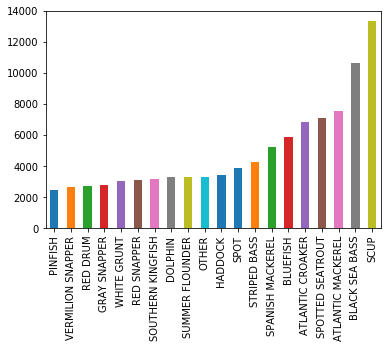

In [60]:
#Let's take a look and see where the new "other" category falls
counts = totals['common'].value_counts()
counts.sort_values(inplace=True)

counts[-20:].plot(kind='bar')

In [61]:
#we can see how many species we are working with now
len(counts)

90

## Data Pre-processing

In [62]:
# Make the categorical variables that are represented by numbers into 'category' datatypes, not int/floats

In [63]:
cats=['SUB_REG', 'AREA', 'AREA_X', 'MODE_FX', 'month','common']

for item in cats:
    totals[item]=totals[item].astype('category')

In [64]:
totals.dtypes

AREA_X      category
MODE_FX     category
SUB_REG     category
common      category
AREA        category
BOAT_HRS     float64
CNTRBTRS     float64
FFDAYS12     float64
month       category
counts         int64
dtype: object

In [65]:
#the 'counts' column we created doesn't really belong there and will mirror other data we have
totals.drop(columns=['counts'], inplace=True)

In [66]:
#our variable names are getting pretty messy - let's rename 'data' to be the current working dataframe
#which is called 'totals' right now.

data = totals.copy()

In [67]:
data.head()

,AREA_X,MODE_FX,SUB_REG,common,AREA,BOAT_HRS,CNTRBTRS,FFDAYS12,month
0,5,3,4,OTHER,C,NaN,1.0,100.0,9
1,5,3,5,OTHER,4,NaN,1.0,12.0,9
2,5,3,5,OTHER,F,NaN,1.0,85.0,9
3,5,3,5,OTHER,D,NaN,1.0,12.0,9
4,5,3,5,OTHER,D,NaN,1.0,0.0,9


In [68]:
y = data['common']
data.drop(columns=['common'], inplace=True)

In [69]:
data.dtypes

AREA_X      category
MODE_FX     category
SUB_REG     category
AREA        category
BOAT_HRS     float64
CNTRBTRS     float64
FFDAYS12     float64
month       category
dtype: object

In [70]:
# fill the BOAT_HRS column with the median
data.BOAT_HRS.fillna(value=data.BOAT_HRS.median(),inplace=True)

In [71]:
data.AREA_X.cat.codes.unique()

array([4, 0, 1, 2, 3])

In [72]:
# turn the categories into their codes
df = pd.DataFrame()
for x in data:
    try:
        df[x]=data[x].cat.codes
    except:
        df[x]=data[x]

# Train the model

In [73]:
m = RandomForestClassifier(oob_score=True, n_jobs=-1, n_estimators=30, max_features=.6,
                           min_samples_leaf=10)
%time m.fit(df, y)


CPU times: user 13.2 s, sys: 1.39 s, total: 14.6 s
Wall time: 8.58 s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=0.6, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=-1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

### Evaluate the model

In [74]:
m.oob_score_

0.5997718690443297

In [75]:
m.n_classes_

90

In [76]:
# import pickle 

# with open('fat_model.pkl','wb') as pickle_file:
#     pickle.dump(m, pickle_file)

In [77]:
m.feature_importances_

array([0.07552168, 0.09186386, 0.12265958, 0.12335546, 0.14571335,
       0.09268166, 0.15890911, 0.18929531])

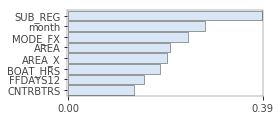

In [78]:
imp = importances(m, df, y, n_samples=-1)
viz = plot_importances(imp)
viz.view()

# Test the model predicting one input

We want to be able to get a user input and predict the most likely classes of fish. Let's test to see if we can give a single set of input variables and make that prediction

In [79]:
array = df.loc[0].as_matrix()
test = array.reshape(1,-1)
m.predict(test)

/home/lubuntu/anaconda3/envs/project/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


array(['BLUEFISH'], dtype=object)

In [80]:
m.predict_proba(test)

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 5.18379707e-03, 1.75930886e-02, 8.91287369e-02,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 6.90867468e-04, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 5.83415421e-01, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.10195539e-04,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        7.35835173e-05, 0.00000000e+00, 4.75125552e-02, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.000000

In [82]:
preds = pd.DataFrame()
#preds['common']=y.unique().sort_values(ascending=False)
preds['likelihood']= m.predict_proba(test)[0]
preds['name']=m.classes_
preds.head()

,likelihood,name
0,0.0,ACADIAN REDFISH
1,0.0,ALMACO JACK
2,0.0,ATLANTIC BUMPER
3,0.0,ATLANTIC COD
4,0.0,ATLANTIC CROAKER


In [83]:
tops = preds.sort_values(by='likelihood', ascending=False)

In [84]:
print(tops.head(3))

    likelihood               name
18    0.583415           BLUEFISH
63    0.216935               SCUP
7     0.089129  ATLANTIC MENHADEN
